In [1]:
import pandas as pd 
import numpy as np 
import datetime
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split 
import math
import plotly as pl

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
####	Get raw data ## Load in each file

column_names = ['X1', 'ID', 'Case Number' ,'Date', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward',

'Community Area', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude', 'Location']


df = pd.read_csv('/content/drive/MyDrive/Crimes_2001_to_present_sample.csv', encoding='utf-8', names=column_names, skiprows=1,low_memory=False)



In [4]:
####	Format data ## Remove columns

#df = df.drop(['X1', 'IUCR', 'X Coordinate', 'Y Coordinate', 'Location'], axis=1) ## Rename columns

df = df.rename(columns={"Date": "Datetime"})




### Change data types

##	Change data type for ID
def trim_fraction(text):

    if '.0' in text:

        return text[:text.rfind('.0')]
    return text

df['ID'] = df['ID'].astype('str') 
df.ID = df.ID.apply(trim_fraction)


In [5]:
##	Change data types for all columns

df['Case Number'] = df['Case Number'].astype(str)

df['Datetime'] = df['Datetime'].astype(str)

df['Block'] = df['Block'].astype(str)

df['Primary Type'] = df['Primary Type'].astype(str)

df['Description'] = df['Description'].astype(str)

df['Location Description'] = df['Location Description'].astype(str)

df['Arrest'] = df['Arrest'].astype(str)

In [6]:
df['Domestic'] = df['Domestic'].astype(str)

df['Beat'] = pd.to_numeric(df['Beat'], errors='coerce')

df['District'] = pd.to_numeric(df['District'], errors='coerce')

df['Ward'] = pd.to_numeric(df['Ward'], errors='coerce')

df['Community Area'] = pd.to_numeric(df['Community Area'], errors='coerce')

df['FBI Code'] = df['FBI Code'].astype(str)

df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

df['Updated On'] = df['Updated On'].astype(str)

df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')

df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')


In [7]:
### Create datetimes

df['Datetime'] = pd.to_datetime(df['Datetime'], format="%m/%d/%Y %I:%M:%S %p", errors='coerce') # Will not work without coerce... R does this automatically

df['Updated On'] = pd.to_datetime(df['Updated On'], format="%m/%d/%Y %I:%M:%S %p", errors='coerce')


#### Create columns

###	Create columns from datetime ## Month name

df['Month'] = df['Datetime'].dt.strftime('%B') ## Month

df['Month Value'] = df['Datetime'].dt.month ## Year Month

df['Year Month'] = df['Datetime'].dt.strftime('%Y-%m') ## Hour

df['Hour'] = df['Datetime'].dt.hour


In [8]:
####	Create unique identifier ## Create unique identifier

df['Identifier'] = df['ID'] + '-' + df['Case Number'] ## Remove duplicates

df = df.sort_values(['Updated On'], ascending=False)
df = df.drop_duplicates('Identifier')
 

#### Crime rate per month per District


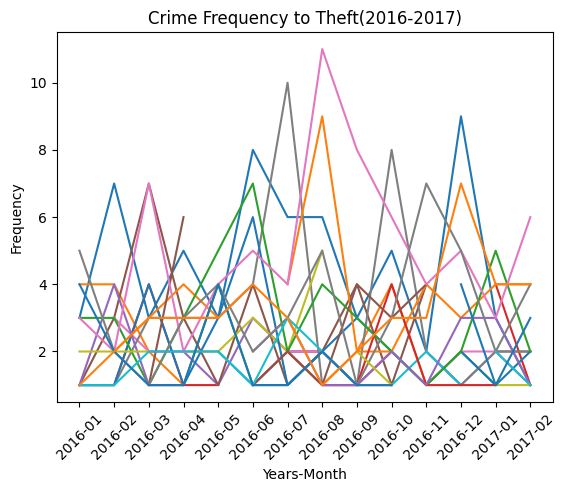

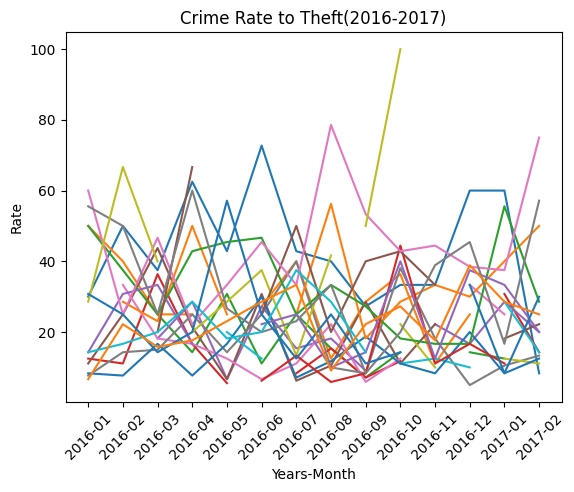

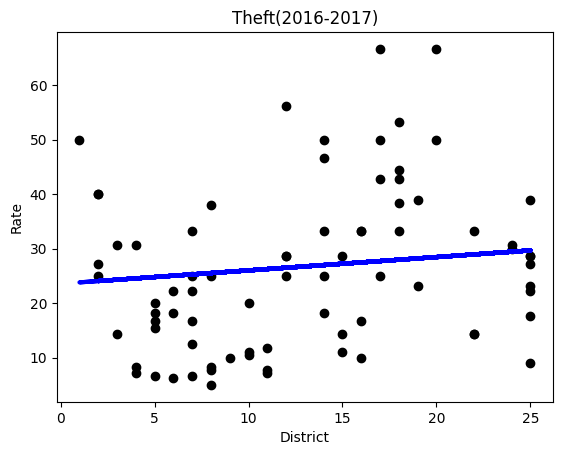

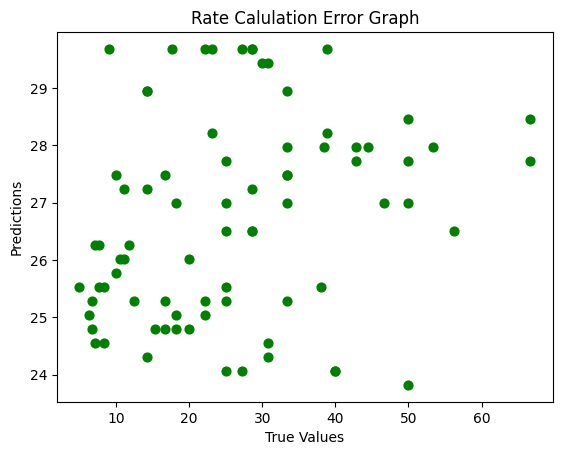

In [10]:
## Get crime counts for each Primary Type

dfDistrict = df.groupby(['Year Month', 'District', 'Primary Type']).size().reset_index()

dfDistrict = dfDistrict.rename(columns={0:'Numerator'})

dfDistrict['ID'] = dfDistrict['Year Month'] + ' ' + dfDistrict['District'].astype(str)




## Get crime counts for each month

dfMonth = df.groupby(['Year Month', 'District']).size().reset_index()

dfMonth = dfMonth.rename(columns={0:'Denominator'})

dfMonth['ID'] = dfMonth['Year Month'] + ' ' + dfMonth['District'].astype(str)

dfMonth = dfMonth[['ID', 'Denominator']]


##	Join to get numerator and denominator together 
dfJoin = pd.merge(dfDistrict, dfMonth, how='left')

dfJoin['Crime Rate'] = dfJoin['Numerator']/dfJoin['Denominator'] * 100


#### Visualisation


## Prepare data frame for Theft from 2016

dfPrimaryType = dfJoin[(dfJoin['Primary Type'] == "THEFT")].reset_index()
dfPrimaryType = dfPrimaryType[(dfPrimaryType['Year Month'] > "2015-12")]




### Plots


## Crime frequency - theft

dfCrimeFreq = dfPrimaryType.pivot(index='Year Month', columns='District')['Numerator']

dfCrimeFreq = dfCrimeFreq.reset_index()

x = list(range(dfCrimeFreq.shape[0]))

y = dfCrimeFreq.drop(['Year Month'], axis=1)

plt.plot(x, y)

xticks = dfCrimeFreq['Year Month']

plt.xticks(x, xticks, rotation=45)

plt.title('Crime Frequency to Theft(2016-2017)')

plt.xlabel('Years-Month')

 
plt.ylabel('Frequency')

plt.show()

## Crime rate - theft

dfCrimeRate = dfPrimaryType.pivot(index='Year Month', columns='District')['Crime Rate']

dfCrimeRate = dfCrimeRate.reset_index()

x = list(range(dfCrimeRate.shape[0]))

y = dfCrimeRate.drop(['Year Month'], axis=1)

plt.plot(x, y)

xticks = dfCrimeRate['Year Month']

plt.xticks(x, xticks, rotation=45)

plt.title('Crime Rate to Theft(2016-2017)')

plt.xlabel('Years-Month')

plt.ylabel('Rate')

plt.show()


xx,yy=[],[]

for a in y.index: #Iterate through columns

    for b in y.columns: #Iterate through rows

        yy.append(y.loc[a,b])

        xx.append(b)

    x1,y1=[],[]

for i in range(len(xx)):

    if not math.isnan(yy[i]):

        x1.append(xx[i])

        y1.append(yy[i])

#train-test set

x1=np.asarray(x1)

x1.shape=(x1.size,1)

y1=np.asarray(y1)

x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.30, random_state=42) #fit model

lm=LinearRegression()

lm.fit(x_train,y_train)

##predict

y_pred=lm.predict(x_test)

 
pred_train=lm.predict(x_train)

#	Plot outputs district vs rate
plt.scatter(x_test,y_test, color='black') 
plt.plot(x_test, y_pred, color='blue', linewidth=3) 
plt.title('Theft(2016-2017)') 
plt.xlabel('District')

plt.ylabel('Rate')

plt.show()

#Plot rate variance

plt.scatter(y_test,y_pred,c='g',s=40) 
plt.title('Rate Calulation Error Graph')
plt.xlabel('True Values') 
plt.ylabel('Predictions')

plt.show()

